# Import Libraries

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
import math
import numpy as np
import random
import json

In [2]:
def load_data(path):
    # Load intents
    with open(path, 'r') as file:
        intents = json.load(file)['intents']

    intents_dict = {}
    response_dict = {}
    for intent in intents:
        intents_dict[intent['tag']] = intent['patterns']
        response_dict[intent['tag']] = intent['responses']

    return intents_dict, response_dict

In [3]:
intents_dict, response_dict = load_data('../clean_data/intents_enriched.json')
n_categories = len(intents_dict)
print(n_categories)

13


Lemmatize, tokenize and extract intent tags. See scripts/helpers.py for more details

In [4]:
def process_intents(intents_dict):
    lemmatizer = WordNetLemmatizer()

    words = []
    intents = []
    words_tokenized = []
    ignore = ['?', '!', '.', ',']

    for intent in intents_dict:
        for pattern in intents_dict[intent]:
            w = nltk.tokenize.word_tokenize(pattern)
            words.extend(w)
            words_tokenized.append((w, intent)) # list of tuples containing list of words and tag
            if intent not in intents:
                intents.append(intent) # unique list of tags

    # find base form of word and remove ignore words
    words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore]
    words = sorted(list(set(words))) # remove duplicates and sort

    intents = sorted(list(set(intents)))

    return words, intents, words_tokenized

In [5]:
words, intents, words_tokenized = process_intents(intents_dict)

In [6]:
lemmatizer = WordNetLemmatizer()
train_x = []
train_y = []

for pair in words_tokenized:
    words_encoded = []
    pattern_words = pair[0] # list of words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for w in words:
        words_encoded.append(1 if w in pattern_words else 0)

    intents_encoded = [0] * len(intents)
    intents_encoded[intents.index(pair[1])] = 1 # pair[1] is the intent

    train_x.append(words_encoded)
    train_y.append(intents_encoded)

train_x = np.array(train_x)
train_y = np.array(train_y)

In [7]:
from sklearn.model_selection import train_test_split

# Split data into training and test set
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

Representation of the bag of words

In [8]:
def bag_of_words(sentence, words, lemmatizer):
    if sentence is None:
        return np.zeros(len(words))
    sentence_words = nltk.tokenize.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
    return np.array(bag)

In [9]:
bag = bag_of_words('Hello', words, lemmatizer)
print(bag)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [10]:
x_train_tensor = torch.from_numpy(train_x).float()
y_train_tensor = torch.from_numpy(train_y).float()
x_test_tensor = torch.from_numpy(test_x).float()
y_test_tensor = torch.from_numpy(test_y).float()
x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape

(torch.Size([3303, 445]),
 torch.Size([3303, 13]),
 torch.Size([826, 445]),
 torch.Size([826, 13]))

An RNN architecture with two linear layers and a softmax output layer. The ReLU activation function is used to introduce non-linearity into the model, followed by a dropout layer to prevent overfitting.

# ToDo
Need to experiment with layer depth, cell types (LSTM, GRU, Bidirectional RNN), hidden size, batch normalization, learning rate decay/schedule, optimizer type (Adam, RMSprop), L1/L2 regularization, and using Leaky ReLU or ELU.

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.h2o(hidden)
        output = self.ReLU(output)
        output = self.dropout(output)
        output = self.softmax(output + 1e-9) # to avoid log(0)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128
n_hidden = 256
rnn = RNN(len(words), n_hidden, len(intents))

In [12]:
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(torch.from_numpy(bag).view(1, -1), hidden)

Test output before training

In [13]:
# from softmax layer outputs, find the most likely category
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # get the index of the greatest value
    category_i = top_i[0].item()
    return intents[category_i], category_i

print(categoryFromOutput(output))

('search_blood_pressure_by_patient_id', 8)


In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.001

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    output, hidden = rnn(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Pick train inputs randomly to avoid overfitting.

In [15]:
def randomChoice(l):
    # for empty intents
    if len(l) == 0:
        return None
    return l[random.randint(0, len(l) - 1)]

# from training data, get a random training example
def randomTrainingExample():
    category = randomChoice(intents)
    line = randomChoice(intents_dict[category])
    category_tensor = torch.tensor([intents.index(category)], dtype=torch.long) # convert category to index tensor
    line_tensor = torch.from_numpy(bag_of_words(line, words, lemmatizer)).view(1, -1) # convert input text to tensor of ones and zeros (bag)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = hospital_search / line = Load hospital near my location
category = search_pharmacy_by_name / line = Find Walmart
category = options / line = How can you help me here?
category = blood_pressure_search / line = I want to search for blood pressure logs for patient by ID
category = thanks / line = Thanks a lot.  You're a hero.
category = thanks / line = Awesome, thanks.  You're a great help
category = options / line = What can you support me with this morning?
category = adverse_drug / line = Do desvenlafaxine and K-Dur have adverse interactions?
category = search_hospital_by_type / line = Find me a children hospital near me
category = search_blood_pressure_by_patient_id / line = View blood pressure records for patient P745620


Train the model

In [16]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iteration number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.3504 Hi, how are you doing? / greeting ✓
10000 10% (0m 14s) 1.9632 so long. Have a terrific rest of your morning. / goodbye ✓
15000 15% (0m 21s) 2.6394 Search for drugstore near my home / search_hospital_by_type ✗ (pharmacy_search)
20000 20% (0m 29s) 1.0850 geriatric hospital near my location / search_hospital_by_type ✓
25000 25% (0m 36s) 2.7179 I want to locate Costco / search_blood_pressure_by_patient_id ✗ (search_pharmacy_by_name)
30000 30% (0m 43s) 3.2310 teaching hospital near me / hospital_search ✗ (search_hospital_by_type)
35000 35% (0m 50s) 2.6427 community hospital near my location / search_hospital_by_params ✗ (search_hospital_by_type)
40000 40% (0m 57s) 3.1060 I want to display blood pressure data for patient P134596 / blood_pressure ✗ (search_blood_pressure_by_patient_id)
45000 45% (1m 4s) 2.6549 Blood pressure readings for patient by name / blood_pressure ✗ (blood_pressure_search)
50000 50% (1m 11s) 0.5450 505 Parnassus Ave, San Francisco, CA 94143 / sear

Might be overfit as-is. Will need hyperparam tuning and testing data

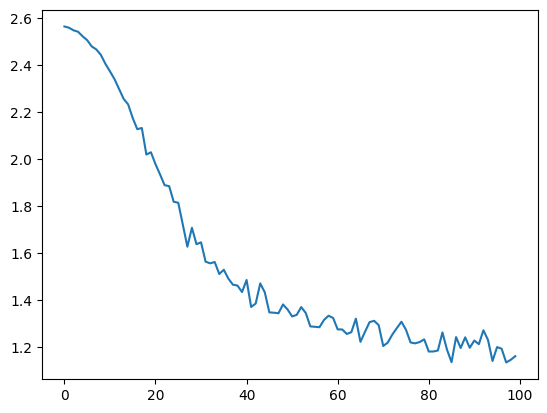

In [17]:
plt.figure()
plt.plot(all_losses)

In [18]:
def evaluate(model, x_test_tensor, y_test_tensor, n_hidden):
    # Set model to evaluation mode
    model.eval()

    correct = 0
    total = y_test_tensor.size(0)

    # Initialize the hidden state
    hidden = model.initHidden()

    with torch.no_grad():  # No need to track gradients
        for i in range(total):
            output, hidden = model(x_test_tensor[i].unsqueeze(0), hidden)  # Pass in the hidden state
            _, predicted = torch.max(output, 1)
            correct += (predicted == y_test_tensor[i].argmax()).sum().item()
            # Optionally: Reset the hidden state at the end of each sequence/test example
            # hidden = model.initHidden()

    accuracy = correct / total
    return accuracy

# Assuming n_hidden is the size of your RNN's hidden layer
accuracy = evaluate(rnn, x_test_tensor, y_test_tensor, n_hidden)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 57.02%


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_advanced_metrics(model, x_test_tensor, y_test_tensor, n_hidden):
    model.eval()  # Set the model to evaluation mode
    
    y_pred = []
    y_true = []

    # Initialize the hidden state
    hidden = model.initHidden()

    with torch.no_grad():
        for i in range(y_test_tensor.size(0)):
            output, hidden = model(x_test_tensor[i].unsqueeze(0), hidden)  # Also pass in and update the hidden state
            _, predicted = torch.max(output, 1)
            y_pred.append(predicted.item())
            y_true.append(y_test_tensor[i].argmax().item())
            # Optionally: Reset the hidden state at the end of each sequence/test example
            # hidden = model.initHidden()

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    
    return precision, recall, f1

precision, recall, f1 = evaluate_advanced_metrics(rnn, x_test_tensor, y_test_tensor, n_hidden)
print(f'Precision: {precision:.2f}') # ratio of true positives to all predicted positives
print(f'Recall: {recall:.2f}') # ratio of true positives to all actual positives
print(f'F1 Score: {f1:.2f}') # harmonic mean of precision and recall

Precision: 0.48
Recall: 0.57
F1 Score: 0.51


/home/riley/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


still not distinguishing hospital search and search hospital by type

In [20]:
def make_confusion(n=10000):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)

    # Just return an output given a line
    def evaluate(line_tensor):
        hidden = rnn.initHidden()

        output, hidden = rnn(line_tensor, hidden)

        return output

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = intents.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + intents, rotation=90)
    ax.set_yticklabels([''] + intents)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

In [22]:
def predict(input_line, n_predictions=3):
    # Just return an output given a line
    def evaluate(line_tensor, model):
        hidden = model.initHidden()
        output, hidden = model(line_tensor, hidden)

        return output
    
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(torch.from_numpy(bag_of_words(input_line, words, lemmatizer)).view(1, -1), rnn)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, intents[category_index]))
            predictions.append([value, intents[category_index]])

predict('Hey there!')
predict('Thanks for that!')
predict('Find me a hospital')


> Hey there!
(-0.77) greeting
(-2.59) search_hospital_by_params
(-2.65) search_blood_pressure_by_patient_id

> Thanks for that!
(-0.29) thanks
(-3.82) search_blood_pressure_by_patient_id
(-3.86) options

> Find me a hospital
(-0.35) search_hospital_by_type
(-2.42) hospital_search
(-3.97) search_blood_pressure_by_patient_id


In [ ]:
# Save the model
torch.save(rnn, '../clean_data/models/intents_classifier.pth')